# Feature Selection

The purpose of this notebook is to:
* Select relevant features
* Reduce dimensionality for some sets of features
* Study correlations in preparation for model testing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from os.path import join

pd.set_option('display.max_columns', None)

%matplotlib inline

In [2]:
parcel = pd.read_pickle(join('../shared_data', 'parcel.pkl'))

In [3]:
parcel.head()

,Major,Minor,PropType,Area,DistrictName,ParcSqFtLot,CurrentZoning,Topography,StreetSurface,InadequateParking,PcntUnusable,MtRainier,Olympics,Cascades,SeattleSkyline,PugetSound,LakeWashington,LakeSammamish,LotDepthFactor,TrafficNoise,AirportNoise,PowerLines,HistoricSite,SteepSlopeHazard,WaterProblems,SqFtTotLiving,no_stories,bath_count,bedroom_count,year_built,year_renovated,heat_system,brick_stone,sq_ft_upper_floor,sale_date,sale_price,sale_reason,appr_land_val,appr_imprv_val,appr_tot_val,appr_date,major_str,minor_str,addr_full,lat,lon,landmarks_counts100,landmarks_counts1000,landmarks_counts20000,light_rail_counts100,light_rail_counts1000,light_rail_counts20000,parks_counts100,parks_counts1000,parks_counts20000,priv_school_counts100,priv_school_counts1000,priv_school_counts20000,pub_school_counts100,pub_school_counts1000,pub_school_counts20000
pin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8121100155,812110,155,R,81.0,SEATTLE,2868,SF 5000,1,1,2,0,0,0,0,0,0,0,0,0,0,0,N,0,N,N,2700,2.0,3,4,2006,0,6,0,0,2007-04-18,0,10,124000,771000,895000,2016-09-19,812110,0155,3844 37TH AVE S,47.568484,-122.285867,0,0,145,0,0,10,0,0,115,0,0,25,0,0,33
3630150210,363015,210,R,75.0,ISSAQUAH,1560,UV,0,1,2,0,0,0,0,0,0,0,0,0,0,0,N,0,N,N,1320,2.0,2,3,2006,0,5,0,0,2004-12-07,2760000,1,282000,191000,473000,2016-08-23,363015,0210,1927 NE KENSINGTON CT,47.548508,-121.997118,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2113700355,211370,355,R,77.0,SEATTLE,4240,SF 5000,1,1,0,0,0,2,0,0,0,0,0,0,0,0,N,0,N,N,1480,1.0,2,3,1986,0,4,0,0,2016-06-01,0,8,110000,241000,351000,2016-09-07,211370,0355,7941 14TH AVE SW,47.530651,-122.353128,0,0,29,0,0,4,0,0,58,0,0,18,0,0,33
4036100060,403610,60,R,64.0,BELLEVUE,9488,R-5,0,1,2,0,0,0,0,0,0,0,0,0,0,0,N,0,N,N,2530,1.0,1,5,1966,0,5,0,0,2016-05-16,710000,1,318000,255000,573000,2016-08-23,403610,0060,11630 SE 47TH PL,47.562031,-122.183779,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
1257202360,125720,2360,R,43.0,SEATTLE,3060,SF 5000,0,1,2,0,0,0,0,0,0,0,0,0,0,0,N,0,N,N,1680,1.5,2,2,1902,0,5,0,0,2002-09-12,0,13,298000,523000,821000,2016-06-22,125720,2360,2139 N 63RD ST,47.674260,-122.331919,0,0,179,0,0,0,0,0,151,0,0,44,0,0,59


In [4]:
# Creating various filters

is_recent_sale = (parcel.sale_date.dt.year >=2013)
is_under_4 = (parcel.sale_price <= 4000000)
is_nonzero = (parcel.sale_price > 80000)
is_good_sale = (np.abs(parcel.sale_price.divide(parcel.appr_tot_val)) < parcel.appr_tot_val.multiply(0.2))

Missing 0 values or 0.0% for DistrictName


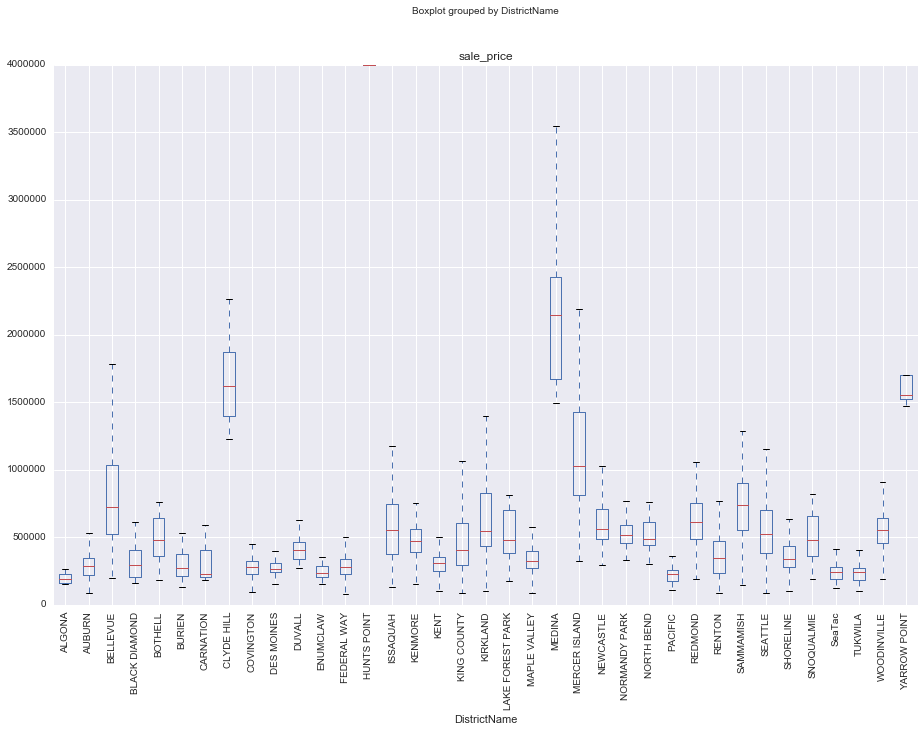

In [5]:
# DistrictName
(
    parcel[is_recent_sale & is_under_4 & is_nonzero & is_good_sale]
    .boxplot(column='sale_price', by='DistrictName', figsize=(15,10), rot=90)
)

# Function to check if there are missing values
def check_cols(cols, df):
    """Prints the number of missing values for each column in cols for the df"""
    for col in cols:
        missing = df[col].isnull().sum()
        percent = (missing/df.shape[0]) * 100
        print('Missing {} values or {}% for {}'.format(missing, percent, col))

check_cols(['DistrictName'], parcel)

# District has some effect on sales price. Specifically Medina is super pricey (where bill gates lives).

Missing 0 values or 0.0% for no_stories
Missing 0 values or 0.0% for bath_count
Missing 0 values or 0.0% for bedroom_count
Missing 0 values or 0.0% for heat_system
Missing 0 values or 0.0% for brick_stone


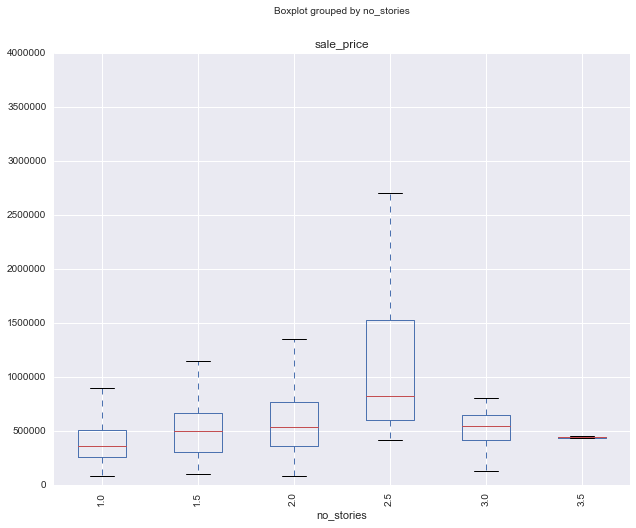

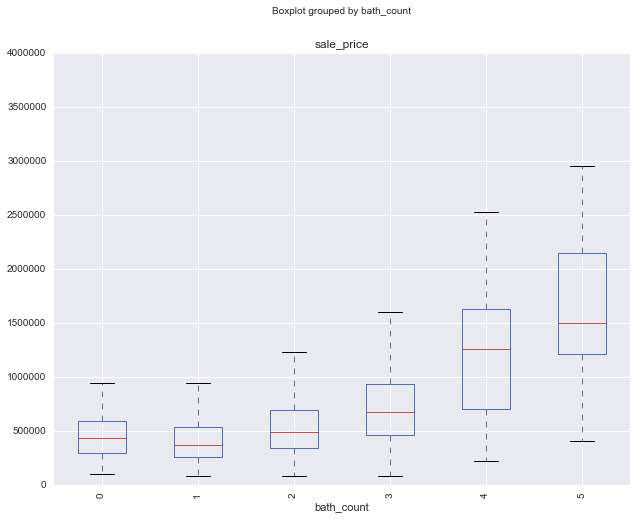

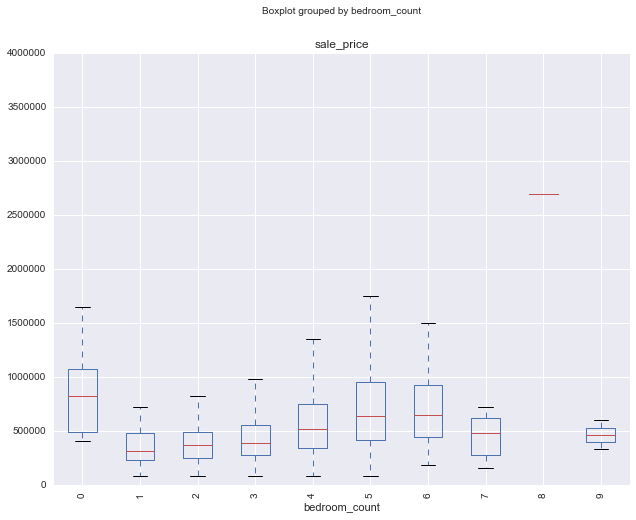

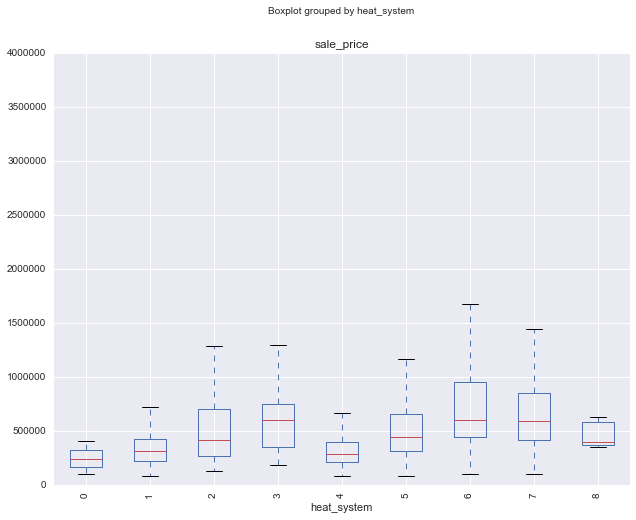

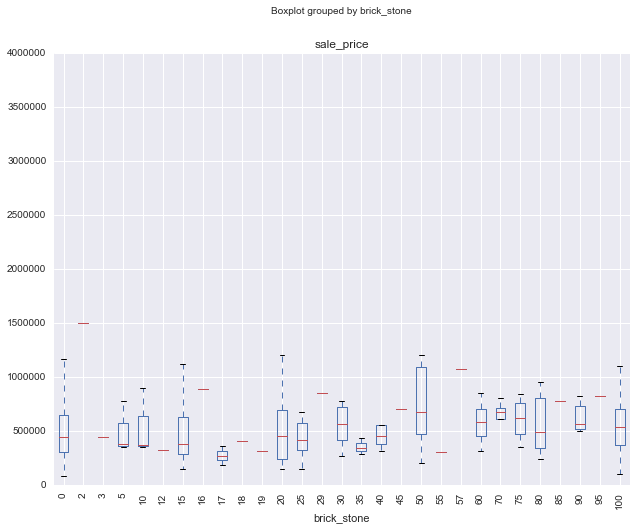

In [6]:
# Checking out some house features
     
HOUSE_FEATURES = ['no_stories', 'bath_count', 'bedroom_count', 'heat_system', 'brick_stone']

check_cols(HOUSE_FEATURES, parcel)

for feature in HOUSE_FEATURES:
    (
        parcel[is_recent_sale & is_under_4 & is_nonzero & is_good_sale]
        .boxplot(column='sale_price', by=feature, figsize=(10,8), rot=90)
    )

# More stories seem to correlate with higher price until you hit 3 stories.

In [7]:
# Bin the useful above data into new columns

def bin_column(df, col, bins, bin_names):
    """Creates a new column 'bin_'+col where the bin names are by default the same as the bin values or the names
    given (if not none)"""
    new_col = 'bin_' + col
    df[new_col] = pd.cut(df[col], bins, labels=bin_names)
    print('New column {}'.format(new_col))
    return df

# bedrooms
br_bins = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 100]
br_bin_names = [0, 1, 2, 3, 4, 5, 6, 7]  # 7 or more is just getting lumped together

parcel = bin_column(parcel, 'bedroom_count', br_bins, br_bin_names)

check_cols(['bedroom_count'], parcel)

New column bin_bedroom_count
Missing 0 values or 0.0% for bedroom_count


In [8]:
# Bin by year built and renovated into decades

yr_bins = [1700, 1800, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020]
yr_labels = [1700, 1800, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]

parcel = bin_column(parcel, 'year_built', yr_bins, yr_labels)
parcel = bin_column(parcel, 'year_renovated', yr_bins, yr_labels)

New column bin_year_built
New column bin_year_renovated


In [9]:
# The median year_renovated is 2000 excluding 0, which means no renovation on record, so I'm replacing 0s with 2000s
# I question how sensible this is...

# parcel[parcel.year_renovated != 0].year_renovated.median()
# Returns 2000

parcel.loc[parcel['year_renovated'] == 0, 'year_renovated'] = 2000

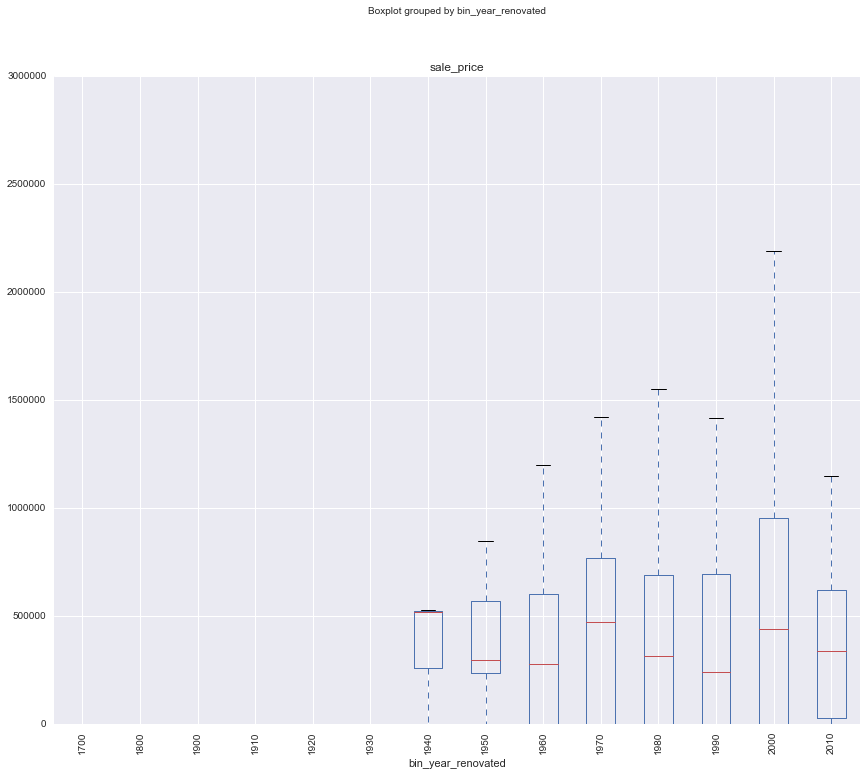

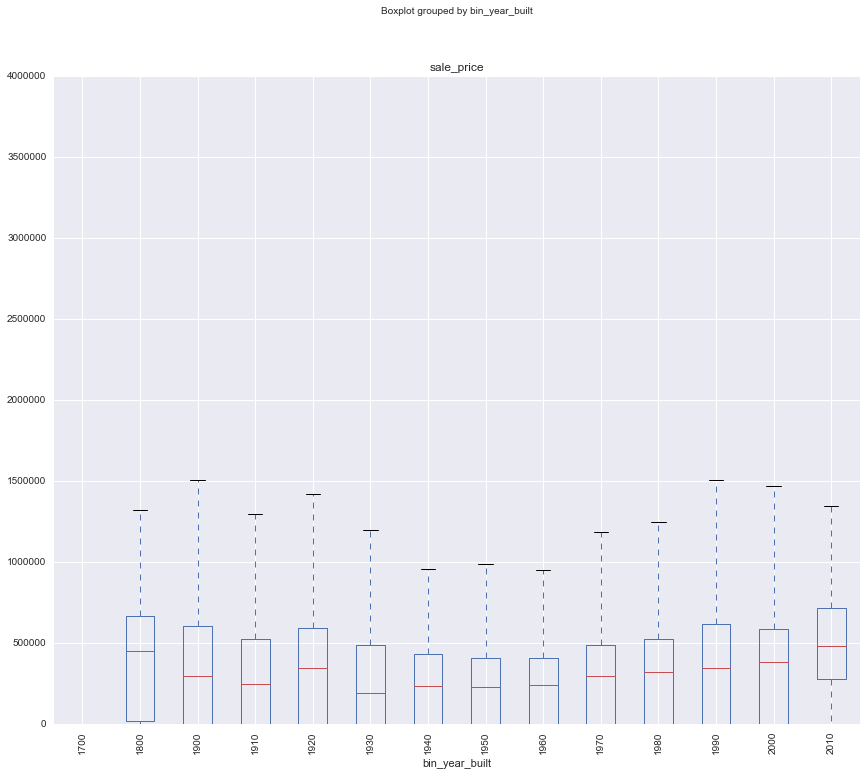

In [10]:
(
    parcel[is_recent_sale & is_good_sale & is_under_4]
    .boxplot(column='sale_price', by='bin_year_renovated', figsize=(14,12), rot=90)
)

(
    parcel[is_recent_sale & is_good_sale & is_under_4]
    .boxplot(column='sale_price', by='bin_year_built', figsize=(14,12), rot=90)
)

Missing 0 values or 0.0% for Topography
Missing 0 values or 0.0% for StreetSurface
Missing 0 values or 0.0% for InadequateParking
Missing 0 values or 0.0% for PcntUnusable


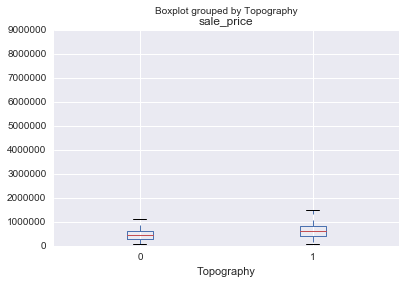

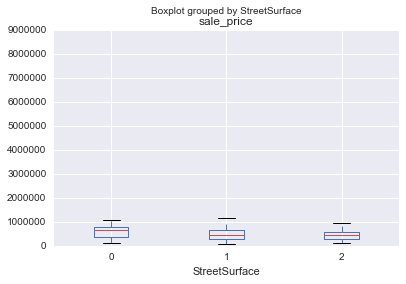

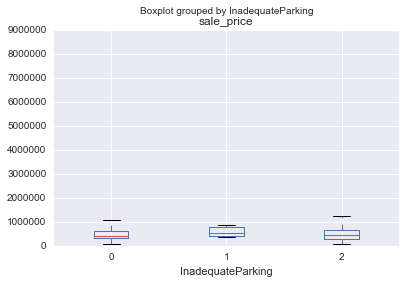

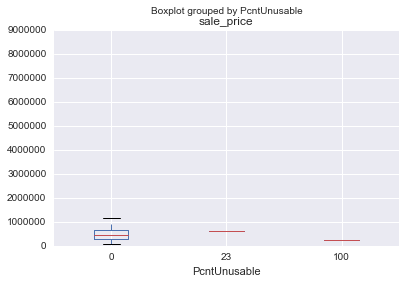

In [11]:
land_features = ['Topography', 'StreetSurface', 'InadequateParking', 'PcntUnusable']

check_cols(land_features, parcel)

for feature in land_features:
    parcel[is_recent_sale & is_nonzero].boxplot(column='sale_price', by=feature)
    
# These seem mostly useless. Try using topography.

Missing 0 values or 0.0% for MtRainier
Missing 0 values or 0.0% for Olympics
Missing 0 values or 0.0% for Cascades
Missing 0 values or 0.0% for SeattleSkyline
Missing 0 values or 0.0% for PugetSound
Missing 0 values or 0.0% for LakeWashington
Missing 0 values or 0.0% for LakeSammamish


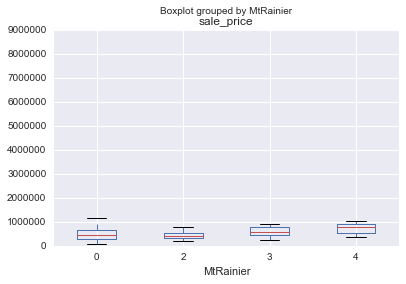

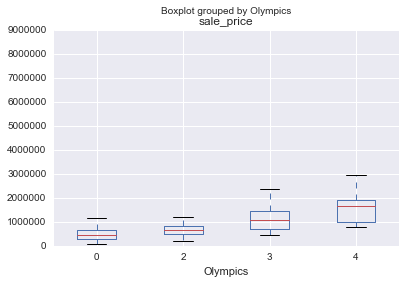

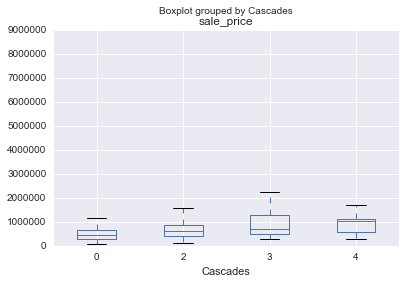

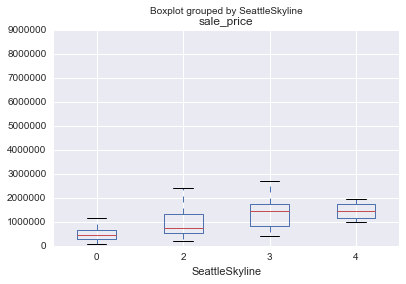

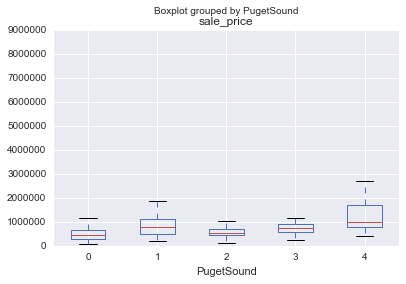

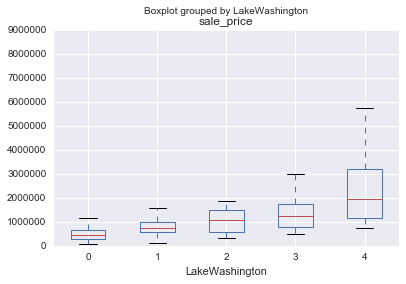

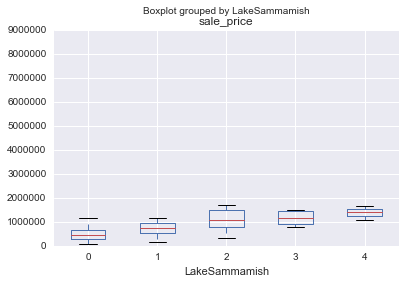

In [12]:
view_features = [
    'MtRainier', 'Olympics', 'Cascades', 'SeattleSkyline',
    'PugetSound', 'LakeWashington', 'LakeSammamish'
]

check_cols(view_features, parcel)

for feature in view_features:
    parcel[is_recent_sale & is_nonzero].boxplot(column='sale_price', by=feature)

# Some of the view features seem like they may be useful especially if dimensionality is reduced

Missing 0 values or 0.0% for LotDepthFactor
Missing 0 values or 0.0% for TrafficNoise
Missing 0 values or 0.0% for AirportNoise
Missing 0 values or 0.0% for PowerLines
Missing 0 values or 0.0% for HistoricSite
Missing 0 values or 0.0% for SteepSlopeHazard
Missing 0 values or 0.0% for WaterProblems


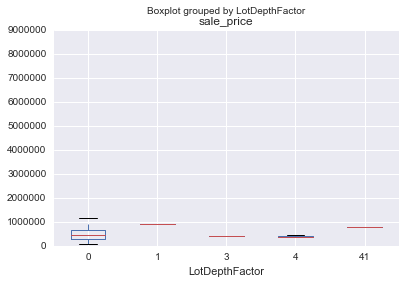

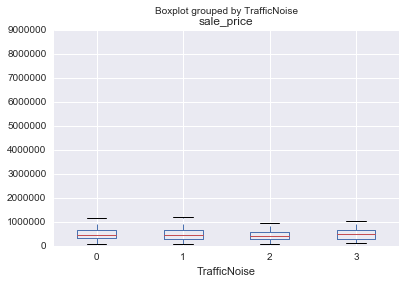

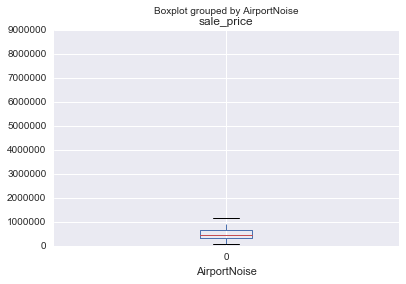

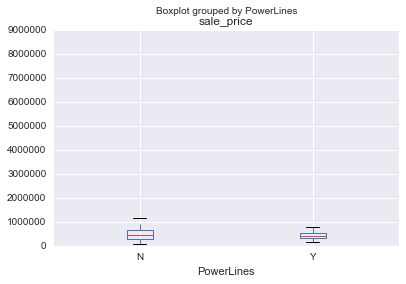

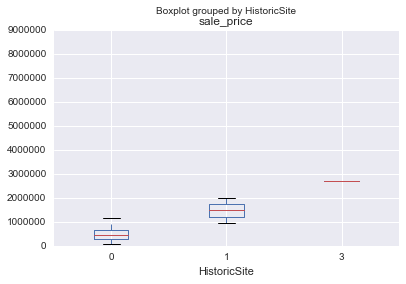

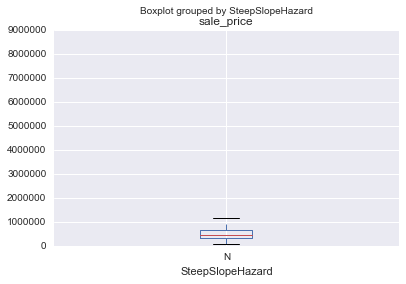

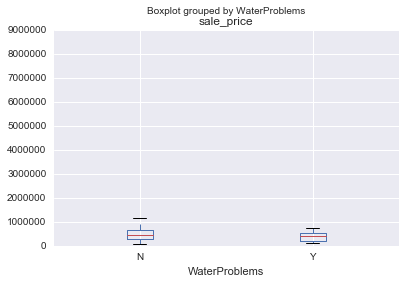

In [13]:
misc_features = [
    'LotDepthFactor',
    'TrafficNoise', 'AirportNoise', 'PowerLines', 'HistoricSite',
    'SteepSlopeHazard', 'WaterProblems'
]

check_cols(misc_features, parcel)

for feature in misc_features:
    parcel[is_recent_sale & is_nonzero].boxplot(column='sale_price', by=feature)

# Historic site seems like it may be slightly predictive

In [14]:
[1 ,2 ,3][-2:]

[2, 3]

Missing landmarks_counts100      0
landmarks_counts1000     0
landmarks_counts20000    0
dtype: int64 values or landmarks_counts100      0.0
landmarks_counts1000     0.0
landmarks_counts20000    0.0
dtype: float64% for ['landmarks_counts100', 'landmarks_counts1000', 'landmarks_counts20000']
Missing parks_counts100      0
parks_counts1000     0
parks_counts20000    0
dtype: int64 values or parks_counts100      0.0
parks_counts1000     0.0
parks_counts20000    0.0
dtype: float64% for ['parks_counts100', 'parks_counts1000', 'parks_counts20000']
Missing light_rail_counts100      0
light_rail_counts1000     0
light_rail_counts20000    0
dtype: int64 values or light_rail_counts100      0.0
light_rail_counts1000     0.0
light_rail_counts20000    0.0
dtype: float64% for ['light_rail_counts100', 'light_rail_counts1000', 'light_rail_counts20000']
Missing pub_school_counts100      0
pub_school_counts1000     0
pub_school_counts20000    0
dtype: int64 values or pub_school_counts100      0.0
pub_sc

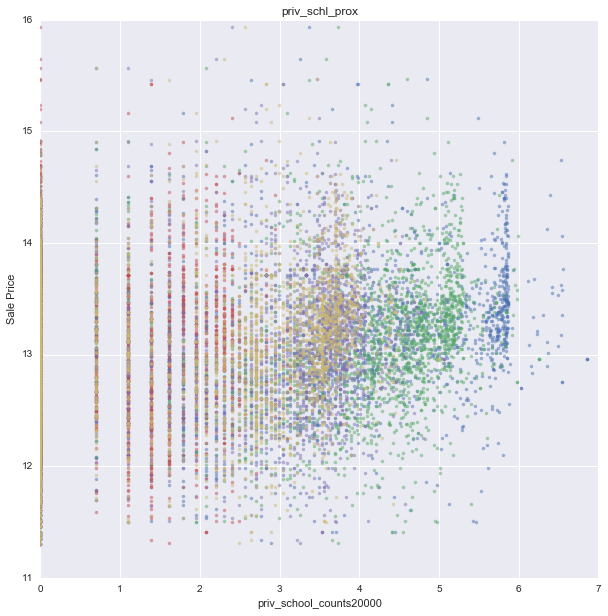

In [29]:
# Proximity features

PROXIMITY_FEATURES = {
    'landmark_prox': ['landmarks_counts100', 'landmarks_counts1000', 'landmarks_counts20000'],
    'light_rail_prox': ['light_rail_counts100', 'light_rail_counts1000', 'light_rail_counts20000'],
    'park_prox': ['parks_counts100', 'parks_counts1000', 'parks_counts20000'],
    'priv_schl_prox': ['priv_school_counts100', 'priv_school_counts1000','priv_school_counts20000'],
    'pub_schl_prox': ['pub_school_counts100','pub_school_counts1000', 'pub_school_counts20000']
}

check_cols(PROXIMITY_FEATURES.values(), parcel)

def plot_prox(df):
    def lg_1(x):
        """Take log(x+1)"""
        return np.log(x+1)
    
    fig = plt.figure(figsize=(10,10))
    # Filter to 'good' sales
    df = df[is_recent_sale & is_nonzero & is_good_sale]
    for name, features in PROXIMITY_FEATURES.items():
        tmp_df = df[features].apply(lg_1)
        tmp_df['sale_price'] = df['sale_price']
        plt.plot(tmp_df[features[-1]], np.log1p(tmp_df['sale_price']), '.', alpha=0.5)
        plt.title(name)
        plt.xlabel(features[-1])
        plt.ylabel('Sale Price')
        axes = plt.gca()
#         axes.set_xlim([0,1e6])
#         axes.set_ylim([0,1e6])
#         plt.clf()

plot_prox(parcel)

# There seems to be a slight correlation especially with the 1000 km range. 20000km seems too big to be useful. 
# TODO: update distances to 5000, 10000, and 20000!

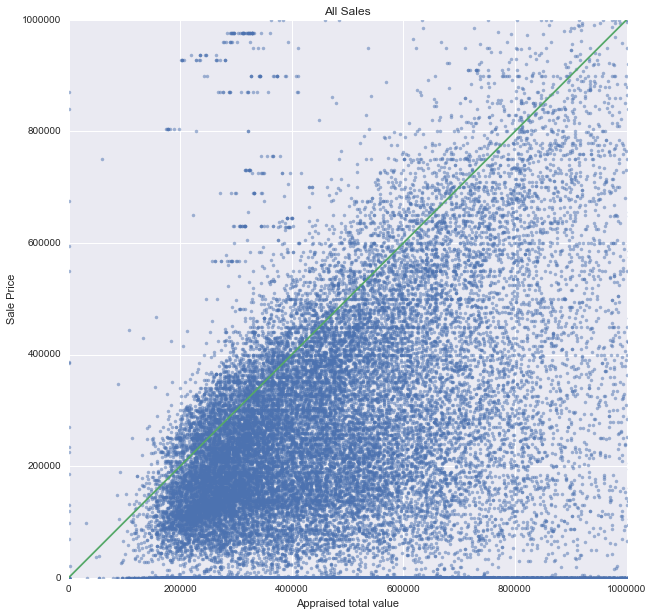

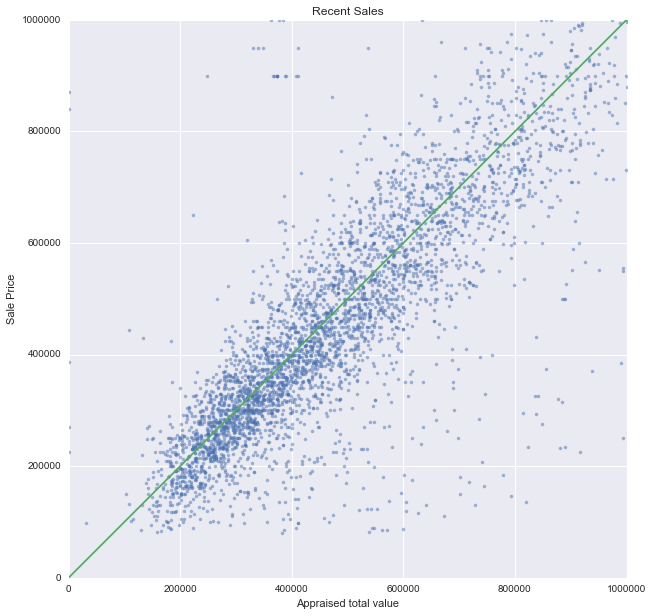

In [16]:

def plot_prices(df, title):
    fig = plt.figure(figsize=(10,10))
    plt.plot(df['appr_tot_val'], df['sale_price'], '.', alpha=0.5)

    valid_assessments = np.linspace(0, 1e7)
    plt.plot(valid_assessments, valid_assessments, '-')
    plt.title(title)
    plt.xlabel('Appraised total value')
    plt.ylabel('Sale Price')

    axes = plt.gca()
    axes.set_xlim([0,1e6])
    axes.set_ylim([0,1e6])

plot_prices(parcel, 'All Sales')
plot_prices(parcel[is_recent_sale & is_nonzero], 'Recent Sales')

# Generally the appraised value is VERY close to actual sale price, but there are some points that seem to be a little off

# Producing X and y for the model

I'm going to focus on recent sales (2013 or later) for now, so I'll filter the data set to that range and also ensure that the sales prices are legit.

## Excluding "bad" sales prices
Based on the above, I'm excluding non-fair and old sales prices. Old sales aren't representative of the current market and sale prices significantly below assessed value aren't representative of a fair market price, which is what I'm interested in.


## Dimensionality Reduction

Based on the analysis above I'm going to reduce the dimensionality of the sets of features pertaining to views and proximity to local points of interest.

In [17]:
# Filter the data to recent 'good' sales only

filtered_df = parcel[is_recent_sale & is_nonzero & is_good_sale & is_under_4]

In [18]:
filtered_df.shape

(4382, 64)

In [19]:
filtered_df.head()

,Major,Minor,PropType,Area,DistrictName,ParcSqFtLot,CurrentZoning,Topography,StreetSurface,InadequateParking,PcntUnusable,MtRainier,Olympics,Cascades,SeattleSkyline,PugetSound,LakeWashington,LakeSammamish,LotDepthFactor,TrafficNoise,AirportNoise,PowerLines,HistoricSite,SteepSlopeHazard,WaterProblems,SqFtTotLiving,no_stories,bath_count,bedroom_count,year_built,year_renovated,heat_system,brick_stone,sq_ft_upper_floor,sale_date,sale_price,sale_reason,appr_land_val,appr_imprv_val,appr_tot_val,appr_date,major_str,minor_str,addr_full,lat,lon,landmarks_counts100,landmarks_counts1000,landmarks_counts20000,light_rail_counts100,light_rail_counts1000,light_rail_counts20000,parks_counts100,parks_counts1000,parks_counts20000,priv_school_counts100,priv_school_counts1000,priv_school_counts20000,pub_school_counts100,pub_school_counts1000,pub_school_counts20000,bin_bedroom_count,bin_year_built,bin_year_renovated
pin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4036100060,403610,60,R,64.0,BELLEVUE,9488,R-5,0,1,2,0,0,0,0,0,0,0,0,0,0,0,N,0,N,N,2530,1.0,1,5,1966,2000,5,0,0,2016-05-16,710000,1,318000,255000,573000,2016-08-23,403610,0060,11630 SE 47TH PL,47.562031,-122.183779,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,5,1960,NaN
7893202650,789320,2650,R,88.0,DES MOINES,7500,RS-7200,0,1,0,0,0,0,0,0,0,0,0,0,0,0,N,0,N,N,1230,1.0,1,3,1953,2000,5,0,0,2015-12-14,255000,18,75000,169000,244000,2016-09-07,789320,2650,20603 1ST PL S,47.418384,-122.334462,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,3,1950,NaN
3529300330,352930,330,R,29.0,KENT,6922,SR-6,0,1,2,0,0,0,0,0,0,0,0,0,0,0,N,0,N,N,1980,2.0,2,3,1991,2000,5,0,0,2013-06-22,206000,8,110000,262000,372000,2016-06-22,352930,0330,11729 SE 229TH PL,47.396020,-122.183738,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1990,NaN
7304300215,730430,215,R,3.0,SHORELINE,8184,R6,0,1,2,0,0,0,0,0,0,0,0,0,0,0,N,0,N,N,980,1.0,1,2,1947,2000,5,0,0,2015-10-23,319000,4,193000,112000,305000,2016-06-20,730430,0215,15524 6TH AVE NE,47.742039,-122.322172,0,0,7,0,0,0,0,0,29,0,0,17,0,0,17,2,1940,NaN
7660100130,766010,130,R,79.0,SEATTLE,6000,LR3,0,1,2,0,0,0,0,0,0,0,0,0,0,0,N,0,N,N,760,1.0,1,2,1927,2000,5,0,0,2016-04-14,200083,1,297000,93000,390000,2016-07-04,766010,0130,1322 12TH AVE S,47.590836,-122.316990,0,2,309,0,0,9,0,2,170,0,0,38,0,0,42,2,1920,NaN


In [21]:
# Replace missing categorical variables with the mode
# and replace missing numeric values with median
from sklearn import decomposition


# Create dummies for district name
X = pd.get_dummies(filtered_df['DistrictName'], prefix='dist', drop_first=True)
# Add topography
X = pd.concat([X, filtered_df['Topography']], axis=1)
# Add StreetSurface dummies
new_data = pd.get_dummies(filtered_df['StreetSurface'], prefix='str_surf', drop_first=True)
X = pd.concat([X, new_data], axis=1)
# Adding dim-reduced view features
GOOD_VIEW_FEATURES = [
    'Olympics', 'Cascades', 'SeattleSkyline',
    'PugetSound', 'LakeWashington', 'LakeSammamish'
]
pca3 = decomposition.PCA(n_components=3)
new_data = pca3.fit_transform(filtered_df[GOOD_VIEW_FEATURES])
new_data = pd.DataFrame(new_data, columns=['View_1', 'View_2', 'View_3'], index=X.index)
X = pd.concat([X, new_data], axis=1)
# PowerLines, HistoricSite
X['PowerLines'] = filtered_df['PowerLines'].map({'Y': 1, 'N': 0})
X['HistoricSite'] = filtered_df['HistoricSite']
# House features
house_features = ['no_stories', 'bath_count', 'bin_bedroom_count']
X = pd.concat([X, filtered_df[house_features]], axis=1)
# Year built/renovated
X = pd.concat([X, filtered_df[['year_renovated', 'year_built']]], axis=1)
# Size features
X = pd.concat([X, filtered_df[['ParcSqFtLot', 'SqFtTotLiving', 'sq_ft_upper_floor']]], axis=1)

# Proximity to points of interest
for name, features in PROXIMITY_FEATURES.items():
#     pca2 = decomposition.PCA(n_components=2)
#     new_data = pd.DataFrame(pca2.fit_transform(filtered_df[features]), columns=[name+'_1', name+'_2'], index=filtered_df.index)
    features = features[-2:]
    new_data = pd.DataFrame(filtered_df[features].values, columns=[name+'_1', name+'_2'], index=filtered_df.index)
    X = pd.concat([X, new_data], axis=1)

# adding lat, lon, appraised total value, appraisal date, and sale price and saving
X = pd.concat([X, filtered_df[['lat', 'lon', 'appr_tot_val', 'appr_date', 'sale_date', 'sale_price']]], axis=1)

In [22]:
X.head()

,dist_AUBURN,dist_BELLEVUE,dist_BLACK DIAMOND,dist_BOTHELL,dist_BURIEN,dist_CARNATION,dist_CLYDE HILL,dist_COVINGTON,dist_DES MOINES,dist_DUVALL,dist_ENUMCLAW,dist_FEDERAL WAY,dist_HUNTS POINT,dist_ISSAQUAH,dist_KENMORE,dist_KENT,dist_KING COUNTY,dist_KIRKLAND,dist_LAKE FOREST PARK,dist_MAPLE VALLEY,dist_MEDINA,dist_MERCER ISLAND,dist_NEWCASTLE,dist_NORMANDY PARK,dist_NORTH BEND,dist_PACIFIC,dist_REDMOND,dist_RENTON,dist_SAMMAMISH,dist_SEATTLE,dist_SHORELINE,dist_SNOQUALMIE,dist_SeaTac,dist_TUKWILA,dist_WOODINVILLE,dist_YARROW POINT,Topography,str_surf_1,str_surf_2,View_1,View_2,View_3,PowerLines,HistoricSite,no_stories,bath_count,bin_bedroom_count,year_renovated,year_built,ParcSqFtLot,SqFtTotLiving,sq_ft_upper_floor,landmark_prox_1,landmark_prox_2,park_prox_1,park_prox_2,light_rail_prox_1,light_rail_prox_2,pub_schl_prox_1,pub_schl_prox_2,priv_schl_prox_1,priv_schl_prox_2,lat,lon,appr_tot_val,appr_date,sale_date,sale_price
pin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4036100060,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,-0.110544,-0.03993,-0.01275,0,0,1.0,1,5,2000,1966,9488,2530,0,0,1,0,1,0,0,0,0,0,0,47.562031,-122.183779,573000,2016-08-23,2016-05-16,710000
7893202650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,-0.110544,-0.03993,-0.01275,0,0,1.0,1,3,2000,1953,7500,1230,0,0,0,0,0,0,1,0,0,0,1,47.418384,-122.334462,244000,2016-09-07,2015-12-14,255000
3529300330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,-0.110544,-0.03993,-0.01275,0,0,2.0,2,3,2000,1991,6922,1980,0,0,0,0,0,0,0,0,0,0,0,47.396020,-122.183738,372000,2016-06-22,2013-06-22,206000
7304300215,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,-0.110544,-0.03993,-0.01275,0,0,1.0,1,2,2000,1947,8184,980,0,0,7,0,29,0,0,0,17,0,17,47.742039,-122.322172,305000,2016-06-20,2015-10-23,319000
7660100130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,-0.110544,-0.03993,-0.01275,0,0,1.0,1,2,2000,1927,6000,760,0,2,309,2,170,0,9,0,42,0,38,47.590836,-122.316990,390000,2016-07-04,2016-04-14,200083


In [23]:
X['bin_bedroom_count'] = X['bin_bedroom_count'].astype(float)

In [24]:
X.dtypes

dist_AUBURN                     float64
dist_BELLEVUE                   float64
dist_BLACK DIAMOND              float64
dist_BOTHELL                    float64
dist_BURIEN                     float64
dist_CARNATION                  float64
dist_CLYDE HILL                 float64
dist_COVINGTON                  float64
dist_DES MOINES                 float64
dist_DUVALL                     float64
dist_ENUMCLAW                   float64
dist_FEDERAL WAY                float64
dist_HUNTS POINT                float64
dist_ISSAQUAH                   float64
dist_KENMORE                    float64
dist_KENT                       float64
dist_KING COUNTY                float64
dist_KIRKLAND                   float64
dist_LAKE FOREST PARK           float64
dist_MAPLE VALLEY               float64
dist_MEDINA                     float64
dist_MERCER ISLAND              float64
dist_NEWCASTLE                  float64
dist_NORMANDY PARK              float64
dist_NORTH BEND                 float64


In [25]:
X.to_pickle(join('../shared_data', 'recent_parc.pkl'))

In [26]:
X.shape

(4382, 68)